In [1]:
if not "cdSet" in globals():
    %cd -q ..
    cdSet = True

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import models.networks as networks
# from collections import OrderedDict
from data.vae import Cityscapes
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pylab as plt

In [5]:
variational_beta = 0.0001
num_epochs = 10
latent_dims = 1024
batch_size = 8
learning_rate = 1e-5
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
H, W = 512, 512

mapping = {
    (0, 0, 0): 0,
    (0, 0, 0): 1,
    (0, 0, 0): 2,
    (0, 0, 0): 3,
    (0, 0, 0): 4,
    (111, 74, 0): 5,
    (81, 0, 81): 6,
    (128, 64, 128): 7,
    (244, 35, 232): 8,
    (250, 170, 160): 9,
    (230, 150, 140): 10,
    (70, 70, 70): 11,
    (102, 102, 156): 12,
    (190, 153, 153): 13,
    (180, 165, 180): 14,
    (150, 100, 100): 15,
    (150, 120, 90): 16,
    (153, 153, 153): 17,
    (153, 153, 153): 18,
    (250, 170, 30): 19,
    (220, 220, 0): 20,
    (107, 142, 35): 21,
    (152, 251, 152): 22,
    (70, 130, 180): 23,
    (220, 20, 60): 24,
    (255, 0, 0): 25,
    (0, 0, 142): 26,
    (0, 0, 70): 27,
    (0, 60, 100): 28,
    (0, 0, 90): 29,
    (0, 0, 110): 30,
    (0, 80, 100): 31,
    (0, 0, 230): 32,
    (119, 11, 32): 33,
    (0, 0, 142): 34,
}

In [6]:
train_loss_avg = []
val_loss_avg = []
n_iter = 0
num_batches = 0
train_loss_avg.append(0)
val_loss_avg.append(0)
pixel_size = batch_size * H * W

In [7]:
def vae_loss(logits, target_onehot, mu, logvar, cur_epoch, name="train"):
    pred = torch.argmax(logits, dim=1).float()
    target = torch.argmax(target_onehot, dim=1)
    recon_loss = F.cross_entropy(logits, target)

    acc = (pred == target).float().mean()

    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    print(
        (
            f"{name}\n"
            f"epoch #{cur_epoch}\n"
            f"reconstruction loss: {recon_loss :.5f}\n"
            f"kldivergence:  {kldivergence: .2f}\n"
            f"variational_beta * kldivergence: {variational_beta * kldivergence: .5f}\n"
            f"batch accuracy: {acc * 100:.2f}\n\n"
        )
    )

    return recon_loss, variational_beta * kldivergence

In [8]:
netVAE = networks.define_VAE(input_nc=34)
netVAE = netVAE.to(device)

dataset_train = Cityscapes(
    root="../../maskgan/data/cityscapes/",
    split="train",
    mode="fine",
    target_type="semantic",
    transform=None,
    target_transform=None,
    transforms=None,
)


dataset_val = Cityscapes(
    root="../../maskgan/data/cityscapes/",
    split="val",
    mode="fine",
    target_type="semantic",
    transform=None,
    target_transform=None,
    transforms=None,
)

dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=2)
dataloader_val = DataLoader(dataset_val, batch_size=1, shuffle=True, num_workers=2)

In [9]:
optimizer = torch.optim.Adam(params=netVAE.parameters(), lr=learning_rate, weight_decay=1e-4)

PATH = "checkpoint_vae/000100.pt"
checkpoint = torch.load(PATH)
netVAE.load_state_dict(checkpoint['vae'])

# optimizer.load_state_dict(checkpoint['vae'])

<All keys matched successfully>

In [10]:
mask_pairs = []

for idx, batch in enumerate(dataloader_val):
    batch = batch.to(device)
    batch = F.one_hot(batch.long(), num_classes=34)
    batch = batch.permute(0, 3, 1, 2).float().contiguous()

    logits, target_onehot, latent_mu, latent_logvar = netVAE(batch)
    losses = vae_loss(
        logits, target_onehot, latent_mu, latent_logvar, name="test", cur_epoch=10
    )
    
    mask_pairs += [(logits[0].argmax(0), target_onehot[0].argmax(0))]
    if idx > 5:
        break
    # backpropagation
#     optimizer.zero_grad()
#     recon_loss.backward()
#     # one step of the optmizer (using the gradients from backpropagation)
#     optimizer.step()
#     n_iter += 1
#     train_loss_avg[-1] += recon_loss.item()

test
epoch #10
reconstruction loss: 0.44990
kldivergence:   903.41
variational_beta * kldivergence:  0.09034
batch accuracy: 86.55


test
epoch #10
reconstruction loss: 0.35530
kldivergence:   817.70
variational_beta * kldivergence:  0.08177
batch accuracy: 89.71


test
epoch #10
reconstruction loss: 0.37956
kldivergence:   830.23
variational_beta * kldivergence:  0.08302
batch accuracy: 87.03


test
epoch #10
reconstruction loss: 0.35856
kldivergence:   751.41
variational_beta * kldivergence:  0.07514
batch accuracy: 88.53


test
epoch #10
reconstruction loss: 0.36072
kldivergence:   871.87
variational_beta * kldivergence:  0.08719
batch accuracy: 89.37


test
epoch #10
reconstruction loss: 0.51391
kldivergence:   819.19
variational_beta * kldivergence:  0.08192
batch accuracy: 85.53


test
epoch #10
reconstruction loss: 0.29076
kldivergence:   715.03
variational_beta * kldivergence:  0.07150
batch accuracy: 92.47




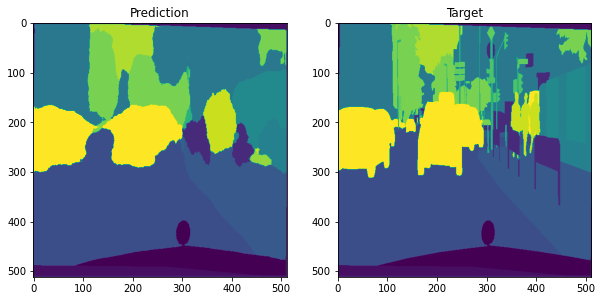

In [11]:
yp, yt = mask_pairs[0]
fig, ax = plt.subplots(ncols=2, figsize=(10, 10))

ax[0].imshow(yp.cpu().numpy() / 34 * 255)
ax[0].set_title("Prediction")
ax[1].imshow(yt.cpu().numpy() / 34 * 255)
ax[1].set_title("Target");

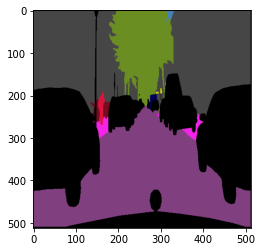

In [12]:
rev_mapping = {mapping[k]: k for k in mapping}
pred = torch.argmax(target_onehot, dim=1) # or e.g. pred = torch.randint(0, 19, (224, 224))
pred_image = torch.zeros(3, pred.shape[1], pred.shape[2], dtype=torch.uint8)
for k in rev_mapping:
    pred_image[:, pred[0]==k] = torch.tensor(rev_mapping[k]).byte().view(3, 1)
plt.imshow(pred_image.permute(1, 2, 0).numpy())

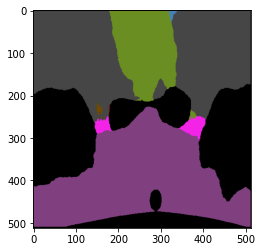

In [13]:
rev_mapping = {mapping[k]: k for k in mapping}
pred = torch.argmax(logits, dim=1) # or e.g. pred = torch.randint(0, 19, (224, 224))
pred_image = torch.zeros(3, pred.shape[1], pred.shape[2], dtype=torch.uint8)
for k in rev_mapping:
    pred_image[:, pred[0]==k] = torch.tensor(rev_mapping[k]).byte().view(3, 1)
plt.imshow(pred_image.permute(1, 2, 0).numpy())